# Model Explainability & Interpretation (XAI)

## 1. Introduction

In this notebook, we open the "black box" of our Machine Learning model. While metrics like F1-Score tell us *how well* the model predicts, XAI techniques tell us *why* it makes those predictions.

### Objectives:
1.  **Global Explanation:** Identify the top drivers of attrition across the entire company using **SHAP Summary Plots**.
2.  **Feature Interaction:** Understand non-linear relationships (e.g., *Does salary matter less as age increases?*) using **Dependence Plots**.
3.  **Local Explanation:** Analyze specific high-risk employees using **LIME** to provide actionable insights for HR.
4.  **Reliability:** Validate the explanations using a **Sanity Check** (Permutation Importance).

In [40]:
import joblib
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shap
import sys

from IPython.display import display, HTML
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings('ignore')

# Add src to path to import our custom utils
sys.path.append('../src')
from utils import load_data, clean_and_encode_data, drop_features # <--- Importamos drop_features

# --- 1. CONFIGURATION ---
# Select your model file. 
# The code below AUTOMATICALLY adapts the data based on the filename.

model_path = '../models/best_xgb_reduced.pkl'  # Opción A: Modelo Reducido
# model_path = '../models/best_xgb_model.pkl'    # Opción B: Modelo Completo

# --- 2. DATA LOADING & PREPROCESSING ---
print(f"🔄 Loading Data for model: {os.path.basename(model_path)}...")

# Load Raw Data
df_raw = load_data('../data/raw_employee_attrition.csv')
df_processed = clean_and_encode_data(df_raw)

X = df_processed.drop('Attrition', axis=1)
y = df_processed['Attrition']

# --- 3. DYNAMIC FEATURE SELECTION ---
# Check if "reduced" is in the filename to apply the same drops as the experiment
if "reduced" in model_path:
    print("⚡ Mode: REDUCED. Dropping redundant features...")
    
    # Must match the list used in 'experiment_feature_selection.py'
    features_to_drop = [
        'JobLevel',           
        'TotalWorkingYears',
        'Age'
    ]
    
    # Apply dropping using our util function
    X = drop_features(X, features_to_drop)
else:
    print("🔹 Mode: FULL. Keeping all features.")

print(f"Final Feature Count: {X.shape[1]}")

# --- 4. TRAIN/TEST SPLIT ---
# Must use same seed as training to replicate the Test Set exactly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 5. LOAD MODEL ARTIFACT ---
if os.path.exists(model_path):
    artifact = joblib.load(model_path)
    model = artifact['model']
    feature_names = artifact['features']
    
    # SAFETY CHECK: Compare model features vs data features
    if len(feature_names) != X_test.shape[1]:
        print(f"⚠️ CRITICAL WARNING: Dimension Mismatch!")
        print(f"   Model expects: {len(feature_names)} features")
        print(f"   Data has:      {X_test.shape[1]} features")
        print("   Did you load the correct model for this dataset version?")
    else:
        print(f"✅ Model loaded successfully: {type(model).__name__}")
        print("   Dimensions match. Ready for XAI.")
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

🔄 Loading Data for model: best_xgb_reduced.pkl...
Loading data from: ../data/raw_employee_attrition.csv
⚡ Mode: REDUCED. Dropping redundant features...
📉 Dropping 3 features: ['JobLevel', 'TotalWorkingYears', 'Age']
Final Feature Count: 41
✅ Model loaded successfully: XGBClassifier
   Dimensions match. Ready for XAI.


## 2. Global Interpretability: SHAP Values

We use **SHAP (SHapley Additive exPlanations)** to understand the global behavior of the model.

### Technique: Summary Plot (Beeswarm)
This plot ranks features by importance and shows their impact direction.
* **Y-Axis:** Features ranked by importance.
* **X-Axis:** SHAP Value (Impact on prediction). Positive = Pushes towards "Yes" (Attrition).
* **Color:** Feature Value (Red = High, Blue = Low).

*Why this technique?* It provides a holistic view of what drives attrition in the company, combining feature importance with feature effects.

Cálculo de SHAP completado.


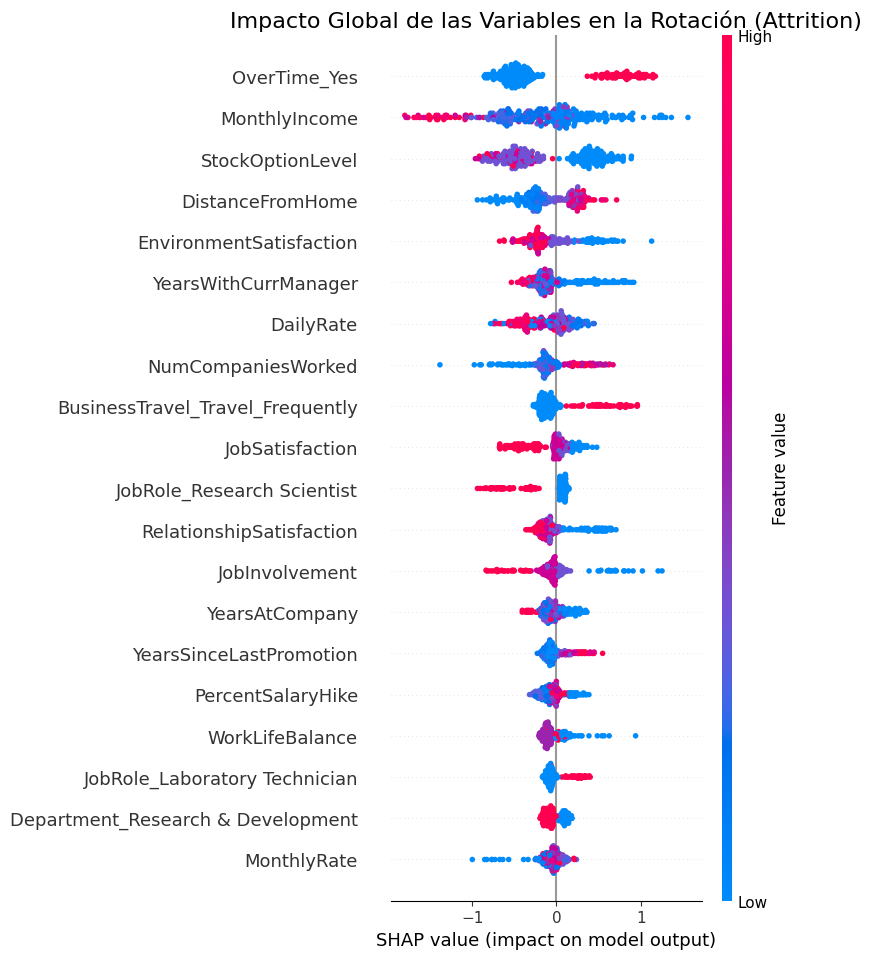

In [41]:
# Inicializar el Explainer
explainer = shap.TreeExplainer(model)

# Calcular SHAP values para todo el test set
# Esto nos dirá cuánto empujó cada variable hacia "Se va" o "Se queda"
shap_values = explainer.shap_values(X_test)

print("Cálculo de SHAP completado.")

# Summary Plot (Tipo Beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Impacto Global de las Variables en la Rotación (Attrition)", fontsize=16)
plt.show()

### 💡 Key Business Insights (Global)
Based on the Beeswarm plot, we identified the primary drivers of turnover:

1.  **`OverTime`**: This is the strongest predictor. The red points (OverTime = Yes) are heavily concentrated on the right (high risk). **Conclusion:** Burnout is the main reason people leave.
2.  **`StockOptionLevel` and `MonthlyIncome`**: Blue points (low values for these features) are on the right. **Conclusion:** Employees with no equity/stock options and low monthly income are significantly more likely to leave. Rising compensation acts as a strong retention tool.

When using the full model (with all features), we observe that `Age` becomes a significant factor, with younger employees showing higher attrition risk. This suggests that younger staff may have different expectations or face different challenges compared to older employees. When using the reduced model, `Age` is removed, so the model learns to identify the age with other correlated features like `YearsAtCompany` and `MonthlyIncome`.

## 3. Feature Interactions

Global importance is not enough. We need to answer questions like: *"Does money solve the OverTime problem?"*

### Technique: Dependence Plots
We visualize how a feature's impact changes as its value increases, colored by a second interacting variable.

Generating plot: Salary vs Overtime...


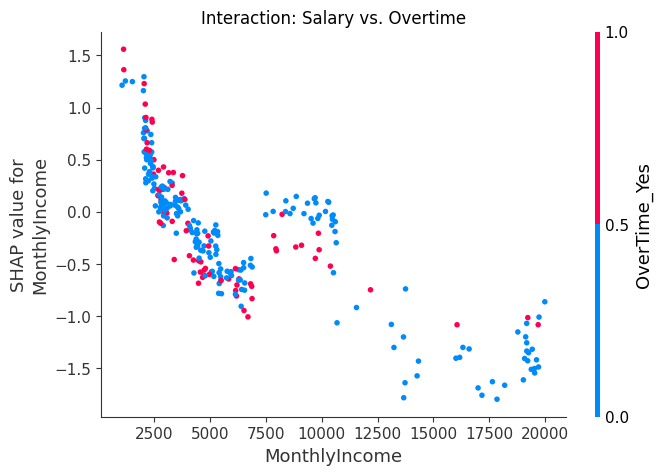

In [42]:
# MonthlyIncome vs. OverTime
# Does paying more compensate for the risk of working overtime?
# Note: Since we did One-Hot Encoding, the column is called 'OverTime_Yes'
print("Generating plot: Salary vs Overtime...")
shap.dependence_plot(
    "MonthlyIncome", 
    shap_values, 
    X_test, 
    interaction_index="OverTime_Yes", 
    show=False
)
plt.title("Interaction: Salary vs. Overtime")
plt.show()

**💡 Interaction Insights**

**The "Danger Zone" (< $4,000)**:
* Risk increases for salaries below $4,000/month.
* A salary correction in the $2.5k-$4k range would have a higher ROI on retention than increasing executive salaries.

**Money vs. Burnout**:
* There are barely red dots in the danger zone, indicating that most employees working overtime are not in the low salary bracket.
* It appears that employees working overtime with a decent salary have a negative risk impact, suggesting that higher pay may mitigate some of the risks associated with overtime work.

## 4. Local Interpretability: Case Study

To make the model actionable for HR managers, we analyze a specific high-risk employee.

### Technique: LIME
We identify the employee with the highest probability of leaving and break down the "Why".

In [43]:
# 1. Find the riskiest employee
y_probs = model.predict_proba(X_test)[:, 1]
risky_idx = np.argsort(y_probs)[-1]
risky_employee = X_test.iloc[risky_idx]

print(f"Analyzing Employee #{risky_idx}")
print(f"Predicted Attrition Probability: {y_probs[risky_idx]:.2%}")

# 2. Setup LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_test.columns.tolist(),
    class_names=['Stay', 'Leave'],
    mode='classification',
    random_state=42
)

# 3. Generate Explanation
exp = lime_explainer.explain_instance(
    data_row=risky_employee, 
    predict_fn=model.predict_proba, 
    num_features=10
)

# 4. Visualize
display(HTML(exp.as_html(show_table=True)))

Analyzing Employee #92
Predicted Attrition Probability: 98.03%


**💡 Local Insights**

The model flagged this employee with a **~97% risk** of leaving. LIME reveals a clear narrative:

* **Why they are leaving (Push Factors):**
    * **`OverTime=Yes`**: The main driver.
    * **`MonthlyIncome`**: Extremely low (~$1,100).
    * **`StockOptionLevel=0`**: No financial incentives.
* **Why they might stay (Pull Factors):**
    * **`JobSatisfaction=Very High`**: Surprisingly, this employee loves their job (Satisfaction level 4).
* **HR Action Plan:** This is a regrettable loss. The employee is engaged but underpaid and overworked. An immediate salary adjustment and workload review could save this specific high-potential employee.

## 5. Evaluation & Sanity Check

Finally, we validate our findings. If `OverTime` is truly the #1 predictor as SHAP says, removing it should break the model.

### Technique: Permutation Importance
We shuffle the `OverTime` column (destroying its information) and measure the drop in F1-Score.

Original F1: 0.4742
Permuted F1: 0.2766
Performance Drop: 0.1976 (-41.7%)


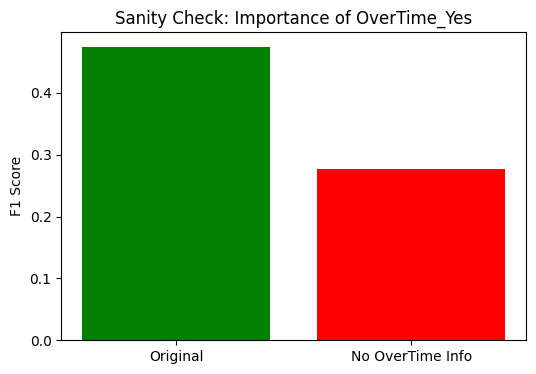

In [44]:
# 1. Baseline F1
y_pred_orig = model.predict(X_test)
f1_orig = f1_score(y_test, y_pred_orig)

# 2. Corrupt "OverTime_Yes"
X_test_permuted = X_test.copy()
# Note: Ensure the column name matches your OneHotEncoder output (e.g., 'OverTime_Yes')
target_feature = 'OverTime_Yes'

# Set seed for reproducibility
np.random.seed(42)

if target_feature in X_test.columns:
    X_test_permuted[target_feature] = np.random.permutation(X_test[target_feature])
    
    # 3. Measure New F1
    y_pred_perm = model.predict(X_test_permuted)
    f1_perm = f1_score(y_test, y_pred_perm)
    
    # 4. Calculate Drop
    drop = f1_orig - f1_perm
    print(f"Original F1: {f1_orig:.4f}")
    print(f"Permuted F1: {f1_perm:.4f}")
    print(f"Performance Drop: {drop:.4f} (-{(drop/f1_orig):.1%})")
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(['Original', 'No OverTime Info'], [f1_orig, f1_perm], color=['green', 'red'])
    plt.title(f"Sanity Check: Importance of {target_feature}")
    plt.ylabel("F1 Score")
    plt.show()
else:
    print(f"Column {target_feature} not found.")

**✅ Final Validation**

The Sanity Check confirms the XAI findings. By randomizing the `OverTime` feature, the model's F1-Score dropped by approximately **42%**.
This proves that the explanations are **truthful**: the model relies heavily on OverTime to make decisions, and it is not just a statistical artifact.

### Systematic Validation (Full Permutation Importance)

The manual test above confirmed that removing `OverTime` hurts the model significantly. However, to be scientifically robust, we cannot rely on a single test run or a single feature.

We now use **Scikit-Learn's `permutation_importance`** to:
1.  **Test all features:** Verify if the global ranking matches SHAP.
2.  **Repeat the experiment:** Run the permutation 10 times (`n_repeats=10`) per feature to ensure the drop in performance is statistically significant and not due to random chance.

Calculating Permutation Importance for all features...
(This helps us validate the SHAP ranking systematically)


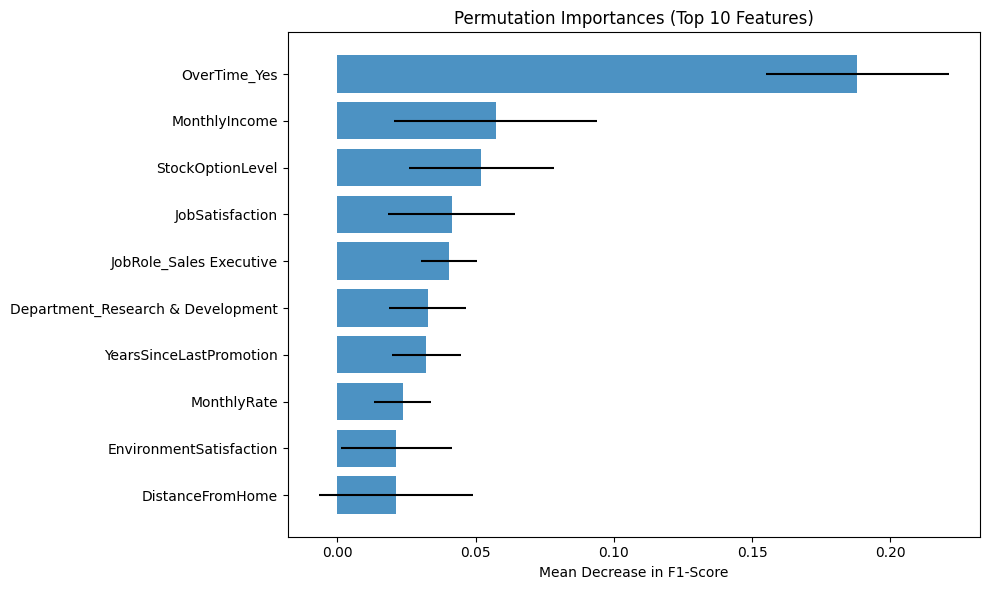

In [45]:
from sklearn.inspection import permutation_importance

# 1. Calculate Permutation Importance
# scoring='f1': We optimize for F1-Score due to class imbalance
# n_repeats=30: Ensures stability (reduces noise)
print("Calculating Permutation Importance for all features...")
print("(This helps us validate the SHAP ranking systematically)")

perm_imp = permutation_importance(
    model, 
    X_test, 
    y_test, 
    scoring='f1', 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1
)

# 2. Sort features by importance (ascending order for barh plot)
sorted_idx = perm_imp.importances_mean.argsort()

# 3. Select only the Top 10 features to keep the plot readable
top_n = 10
top_indices = sorted_idx[-top_n:] 

# 4. Plot using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))

# We include 'xerr' (standard deviation) to show the stability of the importance
ax.barh(
    X_test.columns[top_indices], 
    perm_imp.importances_mean[top_indices], 
    xerr=perm_imp.importances_std[top_indices], # Error bars indicate variability across repeats
    color='#1f77b4',
    alpha=0.8
)

ax.set_title("Permutation Importances (Top 10 Features)")
ax.set_xlabel("Mean Decrease in F1-Score")
fig.tight_layout()
plt.show()

**Key Observations:**
1.  **`OverTime`**: The bar for `OverTime_Yes` is significantly longer than the others. This confirms that our previous analysis is correct. Removing this information causes the model's predictive power to collapse.
2.  **`StockOptionLevel` and `MonthlyIncome`**: Both features appear as two of the most important for the model, which aligns with the previous findings.
3.  **`JobSatisfaction`**: Interestingly, this feature shows up as important here, while it was less prominent in SHAP. This suggests that while it may not have a strong average effect, it is crucial for certain segments of employees. Also, it is a feature that comes up inmediately to mind when thinking about retention strategies.
4.  **`Age`**: When using the full model (with all features), surprisingly, `Age` does not appear in the Top 10 Permutation Importance, despite being important in the SHAP plots. Why? As seen in the 0_preprocessing notebook, `Age` was slightly correlated with several other features. This correlation was not enough to remove it via feature selection, but it does explain this discrepancy, as explained previously: model can infer age with other variables such as `YearsAtCompany` and `MonthlyIncome`.